In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:

import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [ ]:
from load_data import load_data_from_postgres



In [7]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
data = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if data is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

c:\Users\HP\Desktop\Challenges\Telcom\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [9]:
# Aggregate metrics per user
user_metrics = data.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',
    'Total DL (Bytes)': 'sum',
    'Total UL (Bytes)': 'sum'
}).reset_index()

In [ ]:
# Add session frequency per user
user_metrics = data.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',  # Session frequency
    'Dur. (ms)': 'sum',    # Total session duration
    'Total DL (Bytes)': 'sum',
    'Total UL (Bytes)': 'sum'
}).reset_index()
user_metrics.rename(columns={'Bearer Id': 'Session Frequency', 'Dur. (ms)': 'Session Duration'}, inplace=True)
user_metrics['Total Traffic'] = user_metrics['Total DL (Bytes)'] + user_metrics['Total UL (Bytes)']

# Top 10 customers per engagement metric
print("Top 10 Customers by Session Frequency:")
print(user_metrics.nlargest(10, 'Session Frequency')[['MSISDN/Number', 'Session Frequency']])
print("\nTop 10 Customers by Session Duration:")
print(user_metrics.nlargest(10, 'Session Duration')[['MSISDN/Number', 'Session Duration']])
print("\nTop 10 Customers by Total Traffic:")
print(user_metrics.nlargest(10, 'Total Traffic')[['MSISDN/Number', 'Total Traffic']])

In [ ]:
# Normalize all engagement metrics
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_metrics[['Session Frequency', 'Session Duration', 'Total Traffic']] = scaler.fit_transform(
    user_metrics[['Session Frequency', 'Session Duration', 'Total Traffic']]
)

# K-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
user_metrics['Cluster'] = kmeans.fit_predict(user_metrics[['Session Frequency', 'Session Duration', 'Total Traffic']])

# Cluster summary statistics
cluster_summary = user_metrics.groupby('Cluster').agg({
    'Session Frequency': ['min', 'max', 'mean', 'sum'],
    'Session Duration': ['min', 'max', 'mean', 'sum'],
    'Total Traffic': ['min', 'max', 'mean', 'sum']
})
print("\nCluster Summary Statistics:")
print(cluster_summary)

# Visualize clusters
plt.figure(figsize=(8,6))
for c in range(3):
    subset = user_metrics[user_metrics['Cluster'] == c]
    plt.scatter(subset['Session Frequency'], subset['Total Traffic'], label=f'Cluster {c}', alpha=0.5)
plt.xlabel('Session Frequency (normalized)')
plt.ylabel('Total Traffic (normalized)')
plt.title('User Engagement Clusters (K=3)')
plt.legend()
plt.show()

In [ ]:
# Aggregate user total traffic per application and derive top 10 most engaged users per application
app_names = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
app_dl_cols = [f'{app} DL (Bytes)' for app in app_names]
app_ul_cols = [f'{app} UL (Bytes)' for app in app_names]

for app, dl_col, ul_col in zip(app_names, app_dl_cols, app_ul_cols):
    if dl_col in data.columns and ul_col in data.columns:
        data[f'{app}_Total'] = data[dl_col] + data[ul_col]
        app_user_agg = data.groupby('MSISDN/Number')[f'{app}_Total'].sum().reset_index()
        top10 = app_user_agg.nlargest(10, f'{app}_Total')
        print(f"\nTop 10 Most Engaged Users for {app}:")
        print(top10)

# Plot top 3 most used applications
app_totals = {app: data[f'{app}_Total'].sum() for app in app_names if f'{app}_Total' in data.columns}
top3_apps = sorted(app_totals.items(), key=lambda x: x[1], reverse=True)[:3]

plt.figure(figsize=(8,6))
plt.bar([x[0] for x in top3_apps], [x[1]/1e9 for x in top3_apps], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Top 3 Most Used Applications (Total Traffic in GB)')
plt.ylabel('Total Traffic (GB)')
plt.xlabel('Application')
plt.show()

In [ ]:
# Elbow method for optimal k
wcss = []
X = user_metrics[['Session Frequency', 'Session Duration', 'Total Traffic']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

print("\nInterpretation: The optimal k is where the WCSS curve shows a clear 'elbow'. Typically, this is at k=3 for telecom engagement data, but check the plot for confirmation.")

In [10]:
# Add engagement metrics
user_metrics['Total Traffic'] = user_metrics['Total DL (Bytes)'] + user_metrics['Total UL (Bytes)']
user_metrics.rename(columns={'Dur. (ms)': 'Session Duration'}, inplace=True)


In [11]:
# Normalize metrics
scaler = MinMaxScaler()
user_metrics[['Session Duration', 'Total Traffic']] = scaler.fit_transform(user_metrics[['Session Duration', 'Total Traffic']])

In [12]:
# k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
user_metrics['Cluster'] = kmeans.fit_predict(user_metrics[['Session Duration', 'Total Traffic']])

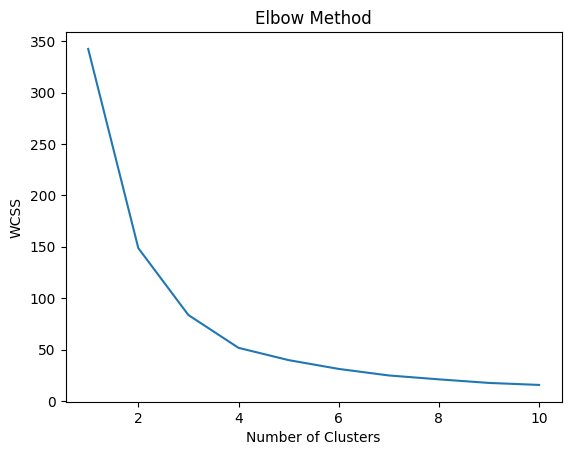

In [13]:
# Elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_metrics[['Session Duration', 'Total Traffic']])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()